# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful (no of people who said this review is helpful)
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not ((no of people who said this review is helpful + (no of people who said no this review is not helpful)). So HelpfulnessDenominator should be greater than HelpfulnessNumerator>
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




To mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('/content/drive/MyDrive/Kaggle Datasets/database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

#Data cleaning¶

First we will check for missing values

In [8]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


We can see that we don't have any null values.

Now we will check for duplicate entries

Pandas duplicated() method helps in analyzing duplicate values only.

keep parameter is set to False, so that only Unique values are taken and the duplicate values are removed from data

In [9]:
# filtered_data = data.drop(columns=['ProductId'])
dup = filtered_data[filtered_data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
dup.shape

(232415, 10)

In [10]:
# example for duplicate entry
# 'AR5J8UI46CURR'
dup[dup['UserId'] == 'A395BORC6FGVXV']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
136303,136304,B002Y7526Y,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
544172,544173,B000U9WZ54,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...


Now we will keep only the first entry and will delete rest of the entry

In [11]:
df = filtered_data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
df.shape

(393933, 10)

Our data points gets reduced to approx 80%

In [12]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(filtered_data.shape[0]*1.0))*100}')

Remaining data is 69.29901100176971


In [13]:
df.shape

(393933, 10)

In [14]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...



**Analysis on Score (Target Variable)**

Now we will create our target variable from review stars. Before that we will filter only those reviews with rating > 3(positive) and less than 3(negative)

In [15]:
df = df[df['Score'] != 3]
df.shape 
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(filtered_data.shape[0]*1.0))*100}')

Remaining data is 64.06217565537405


In [16]:
score = df['Score'].apply(lambda x: 1 if x > 3 else 0)
df['Score'] = score
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


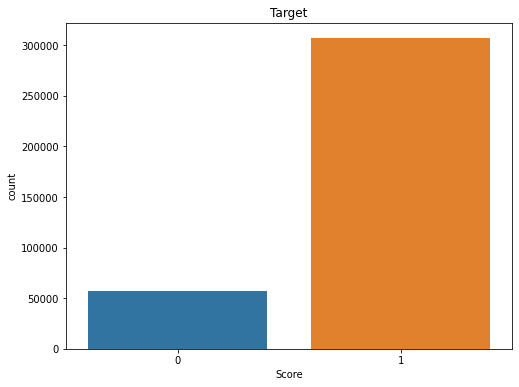

In [17]:
plt.figure(figsize=(8,6))
sns.countplot(df['Score'])
plt.title('Target')
plt.show()

As we can clearly observe that dataset is imbalanced, we cannot use Accuracy as metric to eavluate our Model

So we use Metric called AUC ROC 


AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

**Analysis on HelpfulnessNumerator and HelpfulnessDenominator**

HelpfulnessNumerator - number of users who found the review helpful (no of people who said this review is helpful)

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not ((no of people who said this review is helpful + (no of people who said no this review is not helpful)).

So HelpfulnessDenominator should be greater than HelpfulnessNumerator

In [18]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [19]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
df.shape

(364162, 10)

In [20]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(filtered_data.shape[0]*1.0))*100}')

Remaining data is 64.06182382391539


In [21]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(df.shape)

#How many positive and negative reviews are present in our dataset?
df['Score'].value_counts()

(364162, 10)


1    307054
0     57108
Name: Score, dtype: int64


**Preprocessing Text data**


Now that we have finished deduplication. Our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1.Begin by removing the html tags

2.Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

**finding number of sentences containing HTML tags**

In [22]:
import re
i=0;
for sentences in df['Text'].values:
    if (len(re.findall('<.*?>', sentences))):
        print(i)
        print(sentences)
        break;
    i += 1;

10
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [23]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
#sent_0 = re.sub(r"http\S+", "", sent_0)
#print(sent_0)

In [24]:
# printing some random reviews
sent_0 = df['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = df['Text'].values[1000]
print(sent_1000)
print("="*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?


In [25]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?


In [26]:

# replacing some phrases like won't with will not

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_1000 = decontracted(sent_1000)
print(sent_1000)
print("="*50)

This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can not break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?


In [28]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [29]:
df['text'] = df['Text']

In [30]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    # removing html tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    # removing extra spaces and numbers
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    #to clean the word of any punctuation or special characters
    sentance = re.sub(r'[?|!|\'|"|#]',r'',sentance)
    sentance = re.sub(r'[.|,|)|(|\|/]',r' ',sentance)
    # removing non alphabels
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364162/364162 [02:36<00:00, 2319.73it/s]


In [31]:
#combining required columns
df['clean_text'] = preprocessed_reviews

In [32]:
df = df[['Time','clean_text','Score']]
#reseting index
df = df.reset_index(drop=True)
#saving processed file
df.to_csv('processed_df.csv',index=False)

Reading peprocessed data

In [33]:
df = pd.read_csv('processed_df.csv')
print(df.shape)
df.head()

(364162, 3)


,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364162 entries, 0 to 364161
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        364162 non-null  int64 
 1   clean_text  363184 non-null  object
 2   Score       364162 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB


In [35]:
#one row is empty.we will drop it
df = df.dropna(axis=0)
df.shape

(363184, 3)

As our reviews have been develped over time, we are appying **time based spliting** 

creatin a sample of 80k points for faster training

In [36]:
#sampling 80k points 
df = df.sample(80000,random_state=100)

In [37]:
#sortimg based on time
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)

 **spliting the data to Train,CV and Test**

In [38]:
from sklearn.model_selection import train_test_split
x = df['clean_text']
y = df['Score']

In [39]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=100)

print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (64000,)
shape of X_test is (16000,)
shape of y_train is (64000,)
shape of y_test is (16000,)


In [40]:
X_train.head(3)

76865    used make khanafa dinner guests perfect shippe...
34357    drink black coffee usually grind beans swing s...
64592    item described arrived time would buy item wou...
Name: clean_text, dtype: object

Splitting dataset into Train and Cross Validations

In [41]:
#X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)

#**Featurization**



**1. Bag of Words**

In [42]:
bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (64000, 52207)
shape of X_test_bow is (16000, 52207)


In [43]:
print("the number of unique words ", X_train_bow.get_shape()[1])

the number of unique words  52207


In [44]:
bow_features[0:9]

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaaaaaaaaa',
 'aaaaaah',
 'aaaaaahhhhh',
 'aaaaaahhhhhyaaaaaa',
 'aaaah']

# KNN Classifier

**Finding the optimal K**

In [ ]:
def KNN(Xtr,Ytr,Xte,Yte):
	myList = list(range(0,30))
	neighbors = list(filter(lambda x: x % 2 != 0, myList))
	scores=[]
	for i in neighbors:
		# instantiating brute force method of searching for K values
		Knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

		# fitting the model on crossvalidation train
		Knn.fit(Xtr,Ytr)

		# predict the response on the crossvalidation train
		pred = Knn.predict(Xte)
		# evaluate CV accuracy
		score = f1_score(Yte, pred,average='micro')
		scores.append(score)
    
	MSE = [1 - x for x in scores]

	#determining best k
	optimal_k = neighbors[MSE.index(min(MSE))]
	print('\nThe optimal number of neighbors is %d.' % optimal_k)
	return optimal_k

In [ ]:
KNNBOW = KNN(X_train_bow,y_train,X_test_bow,y_test)


The optimal number of neighbors is 17.


Accuracy on test set: 84.162%
Precision on test set: 0.674
Recall on test set: 0.574
F1-Score on test set: 0.590
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



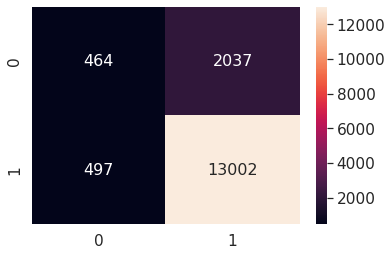

In [ ]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_bow,y_train)
y_pred = knn.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Bi-Grams and n-Grams.**

In [45]:
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit(X_train)

# we use the fitted CountVectorizer to convert the text to vector
X_train_ngram = final_bigram_counts.transform(X_train)
#X_cv_ngram = final_bigram_counts.transform(X_cv)
X_test_ngram = final_bigram_counts.transform(X_test)

In [ ]:
KNNngram = KNN(X_train_ngram,y_train,X_test_ngram,y_test)


The optimal number of neighbors is 25.


Accuracy on test set: 84.806%
Precision on test set: 0.705
Recall on test set: 0.570
F1-Score on test set: 0.584
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



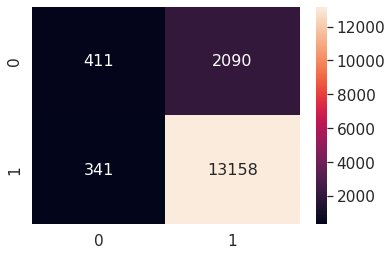

In [ ]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_ngram,y_train)
y_pred = knn.predict(X_test_ngram)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**TF-IDF**

In [46]:
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names()
print("some sample features(unique words in the corpus)",tfidf_features)
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
#X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

some sample features(unique words in the corpus) ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able find', 'able finish', 'able get', 'able give', 'able go', 'able keep', 'able locate', 'able make', 'able order', 'able pick', 'able purchase', 'able put', 'able save', 'able see', 'able stop', 'able take', 'able taste', 'able tell', 'able try', 'able use', 'abomination', 'abroad', 'absence', 'absent', 'absolute', 'absolute best', 'absolute favorite', 'absolutely', 'absolutely adore', 'absolutely amazing', 'absolutely best', 'absolutely delicious', 'absolutely fabulous', 'absolutely fantastic', 'absolutely favorite', 'absolutely great', 'absolutely horrible', 'absolutely love', 'absolutely loved', 'absolutely loves', 'absolutely no', 'absolutely not', 'absolutely nothing', 'absolutely perfect', 'absolutely recommend', 'absolutely wonderful', 'absolutely worth', 'absolutly', 'absorb', 'absorb flavor', 'absorbed', 'abso

In [ ]:
KNNtfidf = KNN(X_train_tfidf,y_train,X_test_tfidf,y_test)


The optimal number of neighbors is 21.


Accuracy on test set: 86.581%
Precision on test set: 0.861
Recall on test set: 0.582
F1-Score on test set: 0.605
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



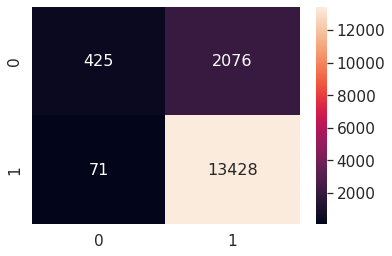

In [ ]:
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train_tfidf,y_train)
y_pred = knn.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Word2Vec**

In [47]:
i=0
sent_list_train=[]
for sent in X_train:
    sent_list_train.append(sent.split())

i=0
sent_list_test=[]
for sent in X_test:
    sent_list_test.append(sent.split())

In [48]:
w2v_model=Word2Vec(sent_list_train,min_count=5,size=50, workers=4)

In [49]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15545
sample words  ['used', 'make', 'dinner', 'guests', 'perfect', 'shipped', 'quickly', 'safely', 'time', 'ordering', 'company', 'drink', 'black', 'coffee', 'usually', 'grind', 'beans', 'swing', 'starbucks', 'get', 'fix', 'figured', 'would', 'save', 'lot', 'money', 'go', 'instant', 'bought', 'recognized', 'brand', 'tried', 'version', 'acceptable', 'folgers', 'not', 'tastes', 'like', 'combination', 'oily', 'home', 'cleaning', 'liquid', 'please', 'amazon', 'trouble', 'return', 'look', 'elsewhere', 'item']


**Avg W2V**

In [50]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in sent_list_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

64000
50


In [51]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in sent_list_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

16000
50


In [52]:
X_test1=sent_vectors_test
X_train1=sent_vectors

In [ ]:
KNNw2v= KNN(X_train1,y_train,X_test1,y_test)


The optimal number of neighbors is 29.


Accuracy on test set: 87.987%
Precision on test set: 0.836
Recall on test set: 0.651
F1-Score on test set: 0.693
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



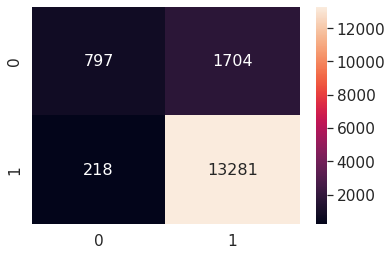

In [ ]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train1,y_train)
y_pred = knn.predict(X_test1)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Conclusion From KNN Classifier**

**Multinomial Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()

**Finding the optimal Alpha Using Gridsearch**

In [ ]:
def NB(Xtr,Ytr,Xte,Yte):
  NB = MultinomialNB()
  alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005]} #params we need to try on classifier
  gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
  gsv.fit(Xtr,Ytr)
  print("Best HyperParameter: ",gsv.best_params_)
  print(gsv.best_score_)
  optimal_alpha=gsv.best_params_['alpha']

  return optimal_alpha

**Bag of Words**

In [ ]:
NB_BOW = NB(X_train_bow,y_train,X_test_bow,y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best HyperParameter:  {'alpha': 1}
0.9000625000000001


**Finding the F1Score of Test data using optimal alpha**

In [ ]:
def NBBOW_F1(Xtr,Ytr,Xte,Yte):
  NB = MultinomialNB(alpha=1)
  NB.fit(Xtr,Ytr)
  y_pred = NB.predict(Xte)
  print("Accuracy on test set: %0.3f%%"%(accuracy_score(Yte, y_pred)*100))
  print("Precision on test set: %0.3f"%(precision_score(Yte, y_pred,average='macro')))
  print("Recall on test set: %0.3f"%(recall_score(Yte, y_pred,average='macro')))
  print("F1-Score on test set: %0.3f"%(f1_score(Yte, y_pred,average='macro')))
  df_cm = pd.DataFrame(confusion_matrix(Yte, y_pred), range(2),range(2))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 91.056%
Precision on test set: 0.851
Recall on test set: 0.787
F1-Score on test set: 0.814


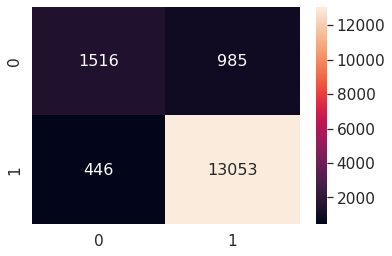

In [ ]:
NBbow = NBBOW_F1(X_train_bow,y_train,X_test_bow,y_test)

**TF IDF**

In [ ]:
NB_tfidf = NB(X_train_tfidf,y_train,X_test_tfidf,y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best HyperParameter:  {'alpha': 0.1}
0.912109375


**Finding the F1Score of Test data using optimal alpha**

In [ ]:
def NBtfidf_F1(Xtr,Ytr,Xte,Yte):
  NB = MultinomialNB(alpha=0.1)
  NB.fit(Xtr,Ytr)
  y_pred = NB.predict(Xte)
  print("Accuracy on test set: %0.3f%%"%(accuracy_score(Yte, y_pred)*100))
  print("Precision on test set: %0.3f"%(precision_score(Yte, y_pred,average='macro')))
  print("Recall on test set: %0.3f"%(recall_score(Yte, y_pred,average='macro')))
  print("F1-Score on test set: %0.3f"%(f1_score(Yte, y_pred,average='macro')))
  df_cm = pd.DataFrame(confusion_matrix(Yte, y_pred), range(2),range(2))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 91.119%
Precision on test set: 0.903
Recall on test set: 0.740
F1-Score on test set: 0.791


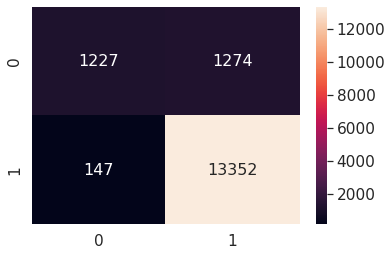

In [ ]:
NBtfidf_f1 = NBtfidf_F1(X_train_tfidf,y_train,X_test_tfidf,y_test)

**Conclusion**

**Logistic Regression** 

In [53]:
def lr(Xtr,Ytr,Xte,Yt):
  LR = LogisticRegression(penalty='l2')
  C_value = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
  gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
  gsv.fit(Xtr,y_train)
  print("Best HyperParameter: ",gsv.best_params_)
  print(gsv.best_score_)
  optimal_C=gsv.best_score_
  return optimal_C

In [83]:
LR = lr(X_train_bow,y_train,X_test_bow,y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'C': 1}
0.9161784632960652


**Unigram and finding the accuracy,F1-score in Test data using optimal C**

In [ ]:
def lruni(Xtr,Ytr,Xte,Yte):
  LR= LogisticRegression(penalty='l2',C=1)
  LR.fit(Xtr,Ytr)
  y_pred =LR.predict(Xte)
  print("Accuracy on test set: %0.3f%%"%(accuracy_score(Yte, y_pred)*100))
  print("Precision on test set: %0.3f"%(precision_score(Yte, y_pred,average='macro')))
  print("Recall on test set: %0.3f"%(recall_score(Yte, y_pred,average='macro')))
  print("F1-Score on test set: %0.3f"%(f1_score(Yte, y_pred,average='macro')))
  df_cm = pd.DataFrame(confusion_matrix(Yte, y_pred), range(2),range(2))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 92.138%
Precision on test set: 0.865
Recall on test set: 0.823
F1-Score on test set: 0.842


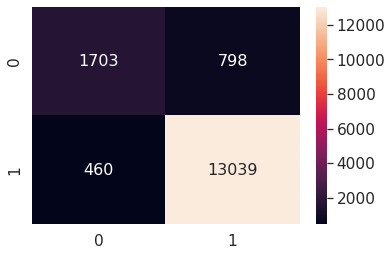

In [ ]:
lrbow = lruni(X_train_bow,y_train,X_test_bow,y_test)

**TFIDF**

In [84]:
LR = lr(X_train_tfidf,y_train,X_test_tfidf,y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'C': 100}
0.9285893925125819


**finding the accuracy,F1-score in Test data using optimal C**

In [85]:
def lrtfidf(Xtr,Ytr,Xte,Yte):
  LR= LogisticRegression(penalty='l2',C=100)
  LR.fit(Xtr,Ytr)
  y_pred =LR.predict(Xte)
  print("Accuracy on test set: %0.3f%%"%(accuracy_score(Yte, y_pred)*100))
  print("Precision on test set: %0.3f"%(precision_score(Yte, y_pred,average='macro')))
  print("Recall on test set: %0.3f"%(recall_score(Yte, y_pred,average='macro')))
  print("F1-Score on test set: %0.3f"%(f1_score(Yte, y_pred,average='macro')))
  df_cm = pd.DataFrame(confusion_matrix(Yte, y_pred), range(2),range(2))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 93.212%
Precision on test set: 0.882
Recall on test set: 0.853
F1-Score on test set: 0.866


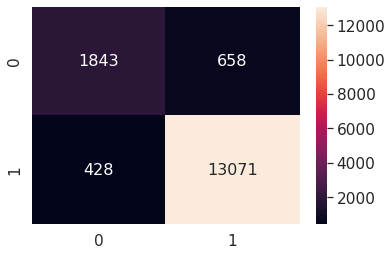

In [86]:
LRIDFDF = lrtfidf(X_train_tfidf,y_train,X_test_tfidf,y_test)

**Avg W2V**

In [ ]:
LRw2v= lr(X_train1,y_train,X_test1,y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'C': 100}
0.8822894374192805


In [ ]:
def LRW2V_F1(Xtr,Ytr,Xte,Yte):
  LR= LogisticRegression(penalty='l2',C=100)
  LR.fit(Xtr,Ytr)
  y_pred =LR.predict(Xte)
  print("Accuracy on test set: %0.3f%%"%(accuracy_score(Yte, y_pred)*100))
  print("Precision on test set: %0.3f"%(precision_score(Yte, y_pred,average='macro')))
  print("Recall on test set: %0.3f"%(recall_score(Yte, y_pred,average='macro')))
  print("F1-Score on test set: %0.3f"%(f1_score(Yte, y_pred,average='macro')))
  df_cm = pd.DataFrame(confusion_matrix(Yte, y_pred), range(2),range(2))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 89.100%
Precision on test set: 0.818
Recall on test set: 0.726
F1-Score on test set: 0.760


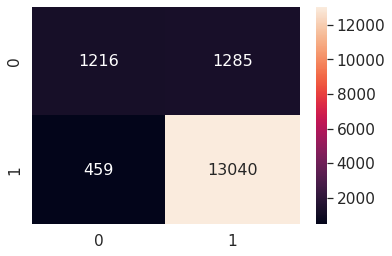

In [ ]:
lrw2v = LRW2V_F1(X_train1,y_train,X_test1,y_test)

**Gradient Boosting Classifer**

**TFIDF**

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
def gbc(Xtr,Ytr,Xte,Yte):
  nEstimator = [60,70,80,90,100,200]
  learningRate= [1,0.5,0.1,0.05,0.01,0.005,0.001]

  GBC = GradientBoostingClassifier()
  hyperParam = [{'n_estimators':nEstimator,'learning_rate': learningRate}]
  gsv = GridSearchCV(GBC,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
  gsv.fit(Xtr,Ytr)
  print("Best HyperParameter: ",gsv.best_params_)

In [56]:
gbtfidf = gbc(X_train_tfidf,y_train,X_test_tfidf,y_test)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best HyperParameter:  {'learning_rate': 0.5, 'n_estimators': 200}


**finding the accuracy,F1-score in Test data using optimal nEstimator and Learning_rate**

In [57]:
def gbctfidf(Xtr,Ytr,Xte,Yte):
  GBC= GradientBoostingClassifier(learning_rate=0.5,n_estimators=200)
  GBC.fit(Xtr,Ytr)
  y_pred =GBC.predict(Xte)
  print("Accuracy on test set: %0.3f%%"%(accuracy_score(Yte, y_pred)*100))
  print("Precision on test set: %0.3f"%(precision_score(Yte, y_pred,average='macro')))
  print("Recall on test set: %0.3f"%(recall_score(Yte, y_pred,average='macro')))
  print("F1-Score on test set: %0.3f"%(f1_score(Yte, y_pred,average='macro')))
  df_cm = pd.DataFrame(confusion_matrix(Yte, y_pred), range(2),range(2))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 91.088%
Precision on test set: 0.866
Recall on test set: 0.769
F1-Score on test set: 0.806


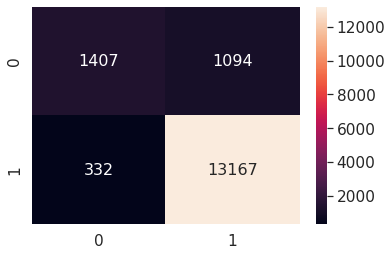

In [63]:
gbc1 = gbctfidf(X_train_tfidf,y_train,X_test_tfidf,y_test)

**Avg W2V**

In [65]:
def gbcw2v(Xtr,Ytr,Xte,Yte):
  GBC= GradientBoostingClassifier(learning_rate=0.5,n_estimators=200)
  GBC.fit(Xtr,Ytr)
  y_pred =GBC.predict(Xte)
  print("Accuracy on test set: %0.3f%%"%(accuracy_score(Yte, y_pred)*100))
  print("Precision on test set: %0.3f"%(precision_score(Yte, y_pred,average='macro')))
  print("Recall on test set: %0.3f"%(recall_score(Yte, y_pred,average='macro')))
  print("F1-Score on test set: %0.3f"%(f1_score(Yte, y_pred,average='macro')))
  df_cm = pd.DataFrame(confusion_matrix(Yte, y_pred), range(2),range(2))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 88.819%
Precision on test set: 0.804
Recall on test set: 0.734
F1-Score on test set: 0.761


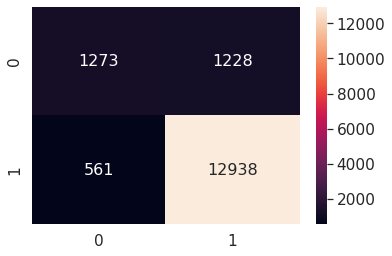

In [66]:
gbcw2v1 = gbcw2v(X_train1,y_train,X_test1,y_test)

**LSTM**

In [70]:
from keras.models import Sequential
from keras.layers import Dense
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


from keras.layers import LSTM
np.random.seed(7)

In [44]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
data = pad_sequences(sequences, maxlen=50)


x_train,x_test,y_train,y_test=train_test_split(data, y, test_size=0.2,shuffle=False)

In [52]:
max_review_length = 600
X_train = pad_sequences(x_train, maxlen=max_review_length)
X_test = pad_sequences(x_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(64000, 600)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [53]:
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,5))
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel('Epochs') 
    plt.ylabel('Binary Crossentropy Loss')
    plt.title('\nBinary Crossentropy Loss VS Epochs')
    plt.legend()
    plt.grid()
    plt.show()

In [60]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [56]:
def labelEncoded(Y):
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    return encoded_Y

y_test=labelEncoded(y_test)
y_train=labelEncoded(y_train)

**Layer 1**

In [ ]:
# create the model
embedding_vecor_length = 32

#Sequential model
layer_1 = Sequential()

#embedding
layer_1.add(Embedding(20000, embedding_vecor_length, input_length=max_review_length))

# 1st LSTM layer
layer_1.add(LSTM(100))

# Dropout layer
layer_1.add(Dropout(0.3))

# output layer
layer_1.add(Dense(1, activation='sigmoid'))

# model summary
print(layer_1.summary())

# Compiling
layer_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_1 = layer_1.fit(X_train, y_train, epochs=10, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 600, 32)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 693,301
Trainable params: 693,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
125/125 [==============================] - 529s 4s/step - loss: 0.3531 - accuracy: 0.8697 - val_loss: 0.2267 - val_accuracy: 0.9100
Epoch 2/10
125/125 [============

In [66]:
score = layer_1.evaluate(x_test, y_test, verbose=0) 
print('Accuracy:', score[1])

Accuracy: 0.8981249928474426


**Conclusion**

Logistic Regression using TFIDF (F1-Score on test set: 86.5%) performed better than all other models

**Loading best ML Model to pickle file**

In [81]:
# loading library
import pickle

In [87]:
# create an iterator object with write permission - model.pkl
with open('lrtfidf_pkl', 'wb') as files:
    pickle.dump(LRIDFDF, files)